In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.spatial.distance import euclidean as eucl_dist
from datetime import datetime
%matplotlib inline

## Vanilla Linear Gaussian State space model (LGSS) 

The aim is to get my hands on sampling and resampling in sequential monte carlo (SMC) algorithm. 
The (very) simple model described here is the following

We observe the data $(y_t)_{t=1}^n$ and we want to 'infer' the distribution of $(x_t)_{t=1}^n \mid (y_t)_{t=1}^n $. We make the hypothesis that the following distribution are true
\begin{align}
y_t \mid x_t &\sim \mathcal{N}(x_t , \sigma_y) \\
x_t \mid x_{t-1} & \sim \mathcal{N}(\theta  x_{t-1} , 1)
\end{align}

In [57]:
T = 250 #length of the chain
theta = 0.5
std_x = 1
std_y = 0.1
x=[np.random.normal(loc=theta, scale=1)]
y =[np.random.normal(loc=x[0], scale= std_y )]
for i in range(T-1):
    x.append(np.random.normal(loc=x[-1]*theta, scale=std_x))
    y.append(np.random.normal(loc=x[-1], scale= std_y ))
x,y = np.array(x), np.array(y)

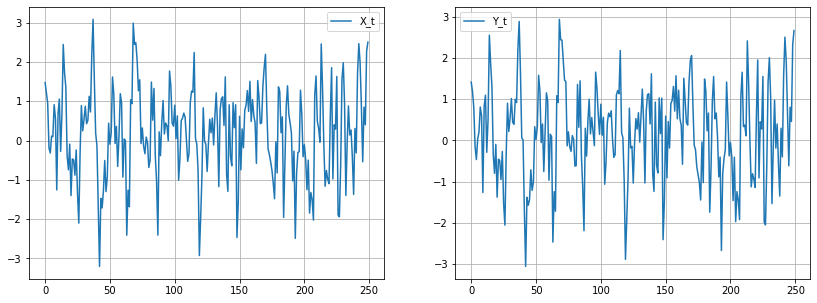

In [58]:
fig, ax = plt.subplots(1,2, figsize = (14,5))
ax[0].plot(x, label='X_t')
ax[0].legend()
ax[0].grid()
ax[1].plot(y, label= 'Y_t')
ax[1].legend()
ax[1].grid()

Il faut garder en tête que $(x_t)_{t=1}^T$ est inconnu. 

Notre but est d'estimer la loi posterieur 
$$ p(x_{1:t} | y_{1:t} )$$
Pour cela, on utilise la technique d'échantillonnage pour obtenir l'estimateur : 
$$ 
\sum_{i=1}^N W_k^i g(x_k^i) \approx \int g(x)f_{\theta}(x) P(dx)
$$ 
Ici, on utilise la technique simple du boostrap . 
Les poids ne dépendent donc que de $x^i_t$ et $y_t$ selon la relation : 
$$
w_t^i = W_{\theta}^i(x_t^i,y_t) = g_{\theta}(y_t \mid x_t^i)
$$

In [60]:
def log_like_evaluation(theta_tilde,seed=1,T=250,n_iter=1,N=1000):
    t1 = datetime.now()
    np.random.seed(seed)
    #T = length of the chain = number of observations
    N = N #Number of particles
    K = 50 #Number of iterations
    L_theta=[]
    for n in range(n_iter):
        x_sampled = np.zeros( (T,N))
        weights = np.ones((T,N))*(1/N)
        for i in range(0,T-1):
            #Resamling: Tirer avec remises parmis les particules selon les poids
            x_sampled[i,:] = np.random.choice(x_sampled[i,:], p=(weights[i,:]/weights[i,:].sum()) )
            #Propagation : Utiliser le noyau de proposition pour rééchantillonner à partir des particules précédentes
            x_sampled[i+1,:] = np.random.normal( loc = x_sampled[i,:]*theta_tilde , scale = 1) 
            #Calculer les nouveaux poids à l'aide de l'équation (1)
            weights[i+1,:] = norm.pdf(np.ones(N)*y[i+1], loc = x_sampled[i+1,:],scale= std_y)
        L_theta.append(-1*(np.log(np.sum(weights, axis=1)).sum() - T*np.log(N)))
    print('Execution time : %f' %(datetime.now()-t1).total_seconds())
    print(L_theta)
    return L_theta

Execution time : 0.118831
[407.1213760665621]
Execution time : 0.107346
[406.1569116436949]
Execution time : 0.107998
[390.33621631712504]
Execution time : 0.131211
[380.6544387663089]
Execution time : 0.116133
[440.1914921579955]
Execution time : 0.139335
[362.4937141151795]
num acquisition: 1, time elapsed: 0.59s
Execution time : 0.136204
[426.5145460778101]
num acquisition: 2, time elapsed: 1.03s
Execution time : 0.135990
[361.68322002852346]
num acquisition: 3, time elapsed: 1.50s
Execution time : 0.137763
[1693.7964418662234]
num acquisition: 4, time elapsed: 1.95s
Execution time : 0.236721
[374.33029286977217]
num acquisition: 5, time elapsed: 2.54s
Execution time : 0.164199
[362.61963468428894]
num acquisition: 6, time elapsed: 3.22s
Execution time : 0.137430
[363.93639067840377]
num acquisition: 7, time elapsed: 3.75s
Execution time : 0.138280
[396.11587805867293]
num acquisition: 8, time elapsed: 4.23s
Execution time : 0.137130
[655.1016073221556]
num acquisition: 9, time elap

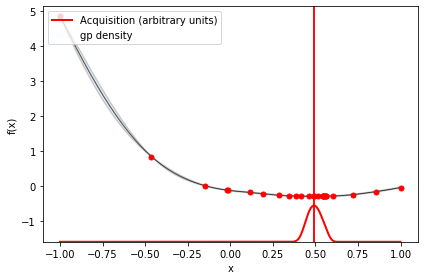

In [61]:
# --- Load GPyOpt
from GPyOpt.methods import BayesianOptimization
import numpy as np

# --- Define your problem
def f(x): return ((6*x-2)**2)*np.sin(12*x-4)
domain = [{'name': 'theta_tilde', 'type': 'continuous', 'domain': (-1,1)}]

# --- Solve your problem
myBopt = BayesianOptimization(f=log_like_evaluation,verbosity=True,Exact_feval=True, domain=domain,normalize_Y=True)
myBopt.run_optimization(max_iter=50, verbosity=True)


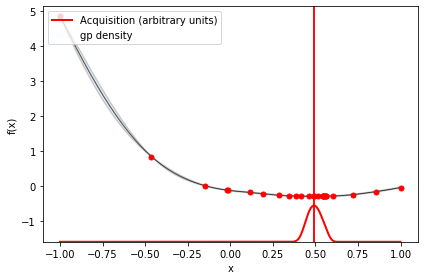

In [64]:
myBopt.plot_acquisition()

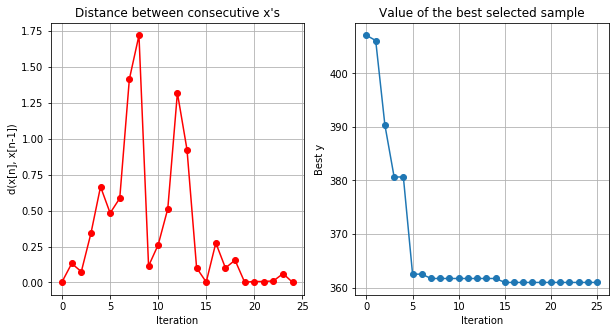

In [62]:
myBopt.plot_convergence()

In [63]:
#Valeur du "meilleur" theta au sens de la vraisemblance obtenu par l'optimisation bayésienne
myBopt.x_opt

array([0.56334067])

In [66]:
l = log_like_evaluation(theta_tilde=0.5,seed=1,T=250,n_iter=1000,N=1000)
l_mean = np.mean(l)


Execution time : 101.686960
[360.6786484781401, 363.8831724628508, 365.07335671962255, 364.2412504548265, 357.1040246441851, 363.9404334149185, 362.1342148105489, 364.77539362884295, 360.16200839525845, 366.0689614721746, 362.8031334512741, 364.7965194340545, 361.88381112760044, 361.7511134708402, 360.79414397893424, 368.25923028921943, 369.92836231930005, 370.81599127273444, 364.7041574785321, 359.09843955902215, 365.5939052654703, 359.1750789537341, 362.32932492252917, 359.2543194328998, 360.5633131477871, 364.0247895014311, 361.85716578799247, 360.3922911327411, 361.32510473099705, 360.49612926131203, 361.2926913450724, 362.0027705883249, 362.49733348268524, 366.949071711894, 361.6273109834078, 364.025240389818, 361.21841221764475, 366.394036017522, 359.69416314047, 370.43643113848475, 363.78780513192305, 361.5364713484714, 362.1081831192573, 360.55924007601266, 363.74648144440835, 359.4434626685663, 354.99414366359497, 357.76990774512797, 360.5089181324379, 366.8277557151189, 364.6

In [67]:
hist, bins_edges = np.histogram(l-l_mean, bins= 100) 

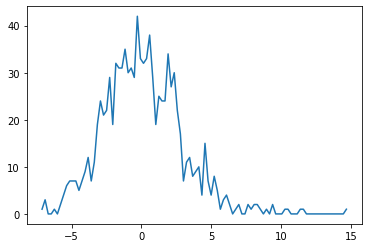

In [68]:
plt.plot(bins_edges[1:],hist)

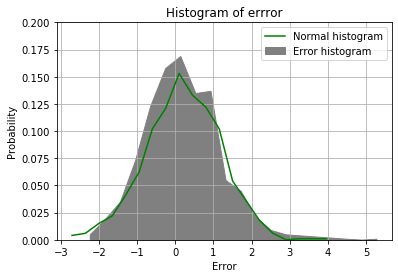

In [69]:
np.random.seed(1)
L_hist, L_bins_edges = np.histogram((l - l_mean)/ np.std(l), 20)
plt.fill_between(L_bins_edges[1:], L_hist/L_hist.sum(),color='grey', label="Error histogram")

normal_sample = np.random.normal(size = 1000)
hist, bins_edges = np.histogram(normal_sample, bins=20)
plt.plot(bins_edges[1:], hist/hist.sum(),color='green', label="Normal histogram")
plt.xlabel('Error')
plt.ylabel('Probability')
plt.title('Histogram of errror')
plt.ylim(0,0.2)
plt.grid(True)
plt.legend()
plt.show()

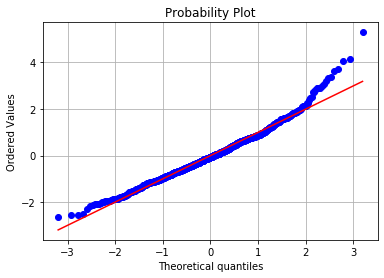

In [70]:
from scipy import stats
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
stats.probplot((l-l_mean)/np.std(l),dist=norm(), plot=ax)
ax.grid()

## Deuxième partie : Estimation de theta par max de vraisemblance

Calculer l'estimateur précédent prend du temps, et il est donc logique de chercher à optimiser notre recherche dans l'espace des paramètres ( ici, $\Theta = [-1, 1]$). On a donc recourt à l'optimisation bayésienne pour limiter le nombre d'appels au filtre particulaire de la section précédente. 

On choisit de modéliser la log-vraisemblance par un processus gaussien, entièrement définit par ses fonctions :
 - m()
 - k(.,.)
 
 La distribution posterieur  est donnée par : 
 $$ 
 l(\theta)\mid D_k \sim \mathcal{N}\Big(\mu(\theta \mid D_k), \sigma^2(\theta \mid D_k) + \sigma_z^2\Bigr)
 $$
avec : 
 - $\Sigma = \kappa(\theta_k, \theta_k) + \sigma^2_z \mathbf{I}_{n \times n}$
 - $\mu(\theta \mid D_k) = m(\theta) + \kappa(\theta, \theta_k) \Sigma^{-1}[ \hat{l}_k - m(\theta)]$
 - $ \sigma^2(\theta \mid D_k) = \kappa(\theta, \theta) - \kappa(\theta, \theta_k)\Sigma^{-1}\kappa(\theta_k, \theta)$
 
 
$\underline{Remarque}$ : On centre l'erreur faite sur la vraisemblance à chaque fois, on considère donc la fonction $m(\theta)= 0$ A priori c'est faux ! Dans le papier, fonction constante considérée


### Remarque computationnelle

$\Sigma^{\top} = \Sigma$ et $\kappa(\theta, \theta_k)^{\top} = \kappa(\theta_k, \theta)$ donc 
$
\begin{align}
\mu(\theta \mid D_k) & = \kappa(\theta, \theta_k) \Sigma^{-1} \hat{l}_k = \kappa(\theta_k, \theta)^{\top} (\Sigma^{-1})^{\top} \hat{l}_k = (\Sigma^{-1} \kappa(\theta_k, \theta) )^{\top} \hat{l}_k\\
\sigma^2(\theta \mid D_k) & = \kappa(\theta, \theta) - (\Sigma^{-1} \kappa(\theta_k, \theta) )^{\top}\kappa(\theta_k, \theta)
\end{align}
$

In [103]:
#qu'est-ce que k dans le papier ? nombre de theta_i et log_lik_i déjà observés 
def RBF_kernel(theta1, theta2,sigma_inv=1):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * sigma_inv * scipy.spatial.distance.cdist(theta1, theta2, 'sqeuclidean')
    return np.exp(sq_norm)

"""
Sigma_inv = scipy.linalg.solve()
mu_post = theta + kerne

def mu(theta,theta_k):
    ### Qu'est-ce que cette fonction ? 
    Sigma = scipy.linalg.solve( , Σ12, assume_a='pos').T
    return theta + kappa(theta, theta_k)

np.linalg.cholesky()
def mu_theta(theta, theta_k, l_k):
    m(theta) + kappa(theta, theta_k)

def sigma(theta,sigma_z=1):
    return kappa(theta, theta) + sigma_z**2 * np.eye(k)
"""
def expected_improvement(l_theta, theta_k, theta, Dk, zeta = 0.01):
    #theta correspond au nouveau theta étudié
    #mu_max = max de la log vraisemblance parmis les données déja étudiées
    #zeta = hyperparamètre à régler
    mu_theta= np.mean(l_theta)
    sigma_theta = np.std(l_theta)
    Z_theta = (mu_theta - mu_max - zeta)/sigma_theta
    Cdf, Pdf = scipy.rand.norm(0,1).cdf(Z_theta),scipy.rand.norm(0,1).pdf(Z_theta)

    return sigma_theta * ( Z_theta * Cdf + pdf)

In [66]:
""" Update of the gaussian process """
def GP_param_update(theta, theta_k,mean,l_k, sigma_z = 1):
    t1 = datetime.now()
    Sigma_k = RBF_kernel(theta_k, theta_k) + (sigma_z ** 2) *np.eye(theta_k.shape[0])
    Sigma_new_obs = RBF_kernel( theta_k, theta)

    solved = scipy.linalg.solve(Sigma_k, Sigma_new_obs ).T
    Sigma_new_obs = RBF_kernel(theta,theta_k)

    mu_post = mean + solved @ (l_k - mean)
    sigma_post = RBF_kernel(theta,theta) -  solved @ RBF_kernel(theta_k, theta)
    print('Time to update parameters : %.2f' %(datetime.now()-t1).total_seconds())
    return mu_post, sigma_post

In [53]:
theta_tilde = np.array([-0.3])
number_of_functions = 5

x,w,l = log_like_evaluation(theta_tilde= theta_tilde)
"""mu_post, sigma_post = GP_param_update(theta_k=theta_k, theta =theta_tilde)
ys = np.random.multivariate_normal(
    mean=mu_post, cov=sigma_post + sigma_z, 
    size=number_of_functions)

theta_k, l_k = np.stack(theta_k, theta), np.stack(l_k,np.mean(l))
"""

Execution time : 93.567734


'mu_post, sigma_post = GP_param_update(theta_k=theta_k, theta =theta_tilde)\nys = np.random.multivariate_normal(\n    mean=mu_post, cov=sigma_post + sigma_z, \n    size=number_of_functions)\n\ntheta_k, l_k = np.stack(theta_k, theta), np.stack(l_k,np.mean(l))\n'

In [109]:
theta=-1
x,w,l = log_like_evaluation(theta_tilde= theta)
mu_k, l_k, theta_k = np.mean(l).reshape(1,1), np.mean(l), np.array([theta]).reshape(1,1)
mu_max=np.max(mu)

In [110]:
K = 1 #number of observations we want to estimate

for i,theta in enumerate(np.linspace(-0.5,1,5)):
    #x,w,l = log_like_evaluation(theta_tilde= theta)
    mu_post, sigma_post = GP_param_update(theta_k=theta_k, theta = np.reshape(theta,(1,1)), mean = np.mean(l).reshape(1,1), l_k=l_k)
    mu_k, l_k, theta_k = np.vstack((mu_k, mu_post)),np.vstack((l_k, np.mean(l) )), np.vstack((theta_k, theta))
    mu_max=np.max(mu_k)
    
    print(i)

Time to update parameters : 0.000369
0
Time to update parameters : 0.000414
1
Time to update parameters : 0.000467
2
Time to update parameters : 0.000531
3
Time to update parameters : 0.000346
4


Execution time : 0.104778
Execution time : 0.082582
Execution time : 0.082677
Execution time : 0.094529
Execution time : 0.082676
Execution time : 0.102988
Execution time : 0.122216


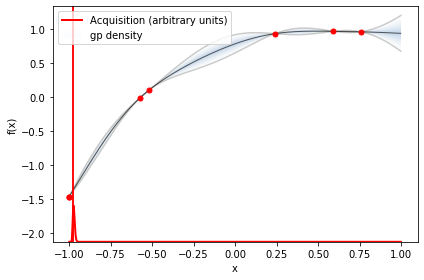

In [59]:
# --- Load GPyOpt
from GPyOpt.methods import BayesianOptimization
import numpy as np

# --- Define your problem
def f(x): return np.sin(x)
domain = [{'name': 'theta_tilde', 'type': 'continuous', 'domain': (-1,1)}]

# --- Solve your problem
myBopt = BayesianOptimization(f=log_like_evaluation, domain=domain)
myBopt.run_optimization(max_iter=40)
myBopt.plot_acquisition()


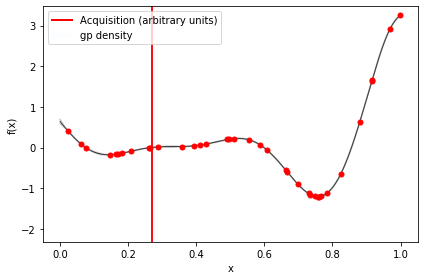

In [31]:
myBopt.run_optimization(max_iter=1)
myBopt.plot_acquisition()